# **6. Feature Transformation and Visualization:**

In [11]:
import matplotlib.pyplot as plt
import numpy as np

In [1]:
from sklearn.datasets import fetch_openml

# download data : MNIST
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data
y = mnist.target

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [2]:
y = y.astype(int)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
X_subset = X_train[:1000]
y_subset = y_train[:1000]

In [5]:
print("Training set shape:", X_train.shape)
print("Validation set shape:", X_valid.shape)
print("Test set shape:", X_test.shape)

Training set shape: (44800, 784)
Validation set shape: (11200, 784)
Test set shape: (14000, 784)


In [6]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

### **Apply Principal Component Analysis (PCA) to transform the original data into a lower-dimensional space.**

In [7]:
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense

pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.fit(X_train).transform(X_test)

### **Train a neural network model on the PCA-transformed data and compare its performance with the model trained on the original data.**

**Model # 1**

In [8]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization

# Define models with modified input size
model1 = Sequential([
    Dense(64, activation='relu', input_shape=(50,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model2 = Sequential([
    Dense(128, activation='relu', input_shape=(50,)),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

model3 = Sequential([
    Dense(256, activation='relu', input_shape=(50,)),
    BatchNormalization(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])

In [9]:
# Assemble models
models = [model1, model2, model3]
for model in models:
    model.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy']) # categorical_crossentropy

# Training models
# Evaluate each model and compare the results
history_dict = {}
best_accuracy = 0
best_model_index = 0

for i, model in enumerate(models, start=1):
    print(f"Training model {i}")
    history = model.fit(X_train_pca, y_train,
                        epochs=20,
                        verbose=1,
                        validation_data=(X_valid_pca, y_valid))

    history_dict[f'model_{i}'] = history.history

    # Find the maximum validation accuracy for this model
    max_val_accuracy = max(history.history['val_accuracy'])
    print(f"Maximum validation accuracy for Model {i}: {max_val_accuracy}")

    # Compare to find the best model
    if max_val_accuracy > best_accuracy:
        best_accuracy = max_val_accuracy
        best_model_index = i

# Print the best model information
print("")
print("==================================================")
print(f"The best model is Model {best_model_index} with a validation accuracy of {best_accuracy}")

Training model 1
Epoch 1/20
1400/1400 [==============================] - 5s 2ms/step - loss: 0.4116 - accuracy: 0.8755 - val_loss: 0.1714 - val_accuracy: 0.9471
Epoch 2/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1722 - accuracy: 0.9465 - val_loss: 0.1249 - val_accuracy: 0.9622
Epoch 3/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1345 - accuracy: 0.9575 - val_loss: 0.1080 - val_accuracy: 0.9655
Epoch 4/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1140 - accuracy: 0.9644 - val_loss: 0.0962 - val_accuracy: 0.9708
Epoch 5/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.1006 - accuracy: 0.9678 - val_loss: 0.0948 - val_accuracy: 0.9712
Epoch 6/20
1400/1400 [==============================] - 4s 3ms/step - loss: 0.0922 - accuracy: 0.9698 - val_loss: 0.0879 - val_accuracy: 0.9732
Epoch 7/20
1400/1400 [==============================] - 3s 2ms/step - loss: 0.0823 - accuracy: 0.9736 - val_loss: 0.089

In [10]:
mse_test1 = model1.evaluate(X_test_pca, y_test)
mse_test2 = model2.evaluate(X_test_pca, y_test)
mse_test3 = model3.evaluate(X_test_pca, y_test)

438/438 [==============================] - 1s 2ms/step - loss: 0.0763 - accuracy: 0.9806


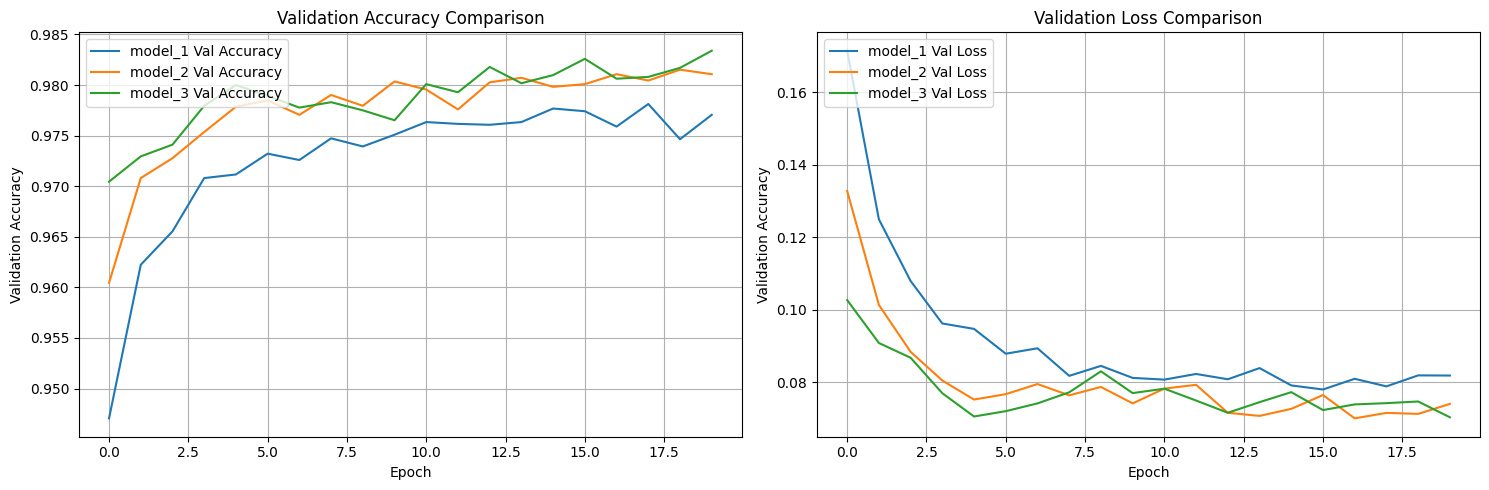

In [13]:
def compare_models_acu(history_dict1, history_dict2):
    plt.figure(figsize=(15, 5))

    # Plot first subplot for Validation Accuracy
    plt.subplot(1, 2, 1)
    for key in history_dict1:
        plt.plot(history_dict1[key]['val_accuracy'], label=f'{key} Val Accuracy')
    plt.title('Validation Accuracy Comparison')
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    # Plot second subplot for Validation Loss
    plt.subplot(1, 2, 2)
    for key in history_dict2:
        plt.plot(history_dict2[key]['val_loss'], label=f'{key} Val Loss')
    plt.title('Validation Loss Comparison')
    plt.ylabel('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.grid(True)

    plt.tight_layout()  # Adjust layout to prevent overlapping
    plt.show()

compare_models_acu(history_dict, history_dict)

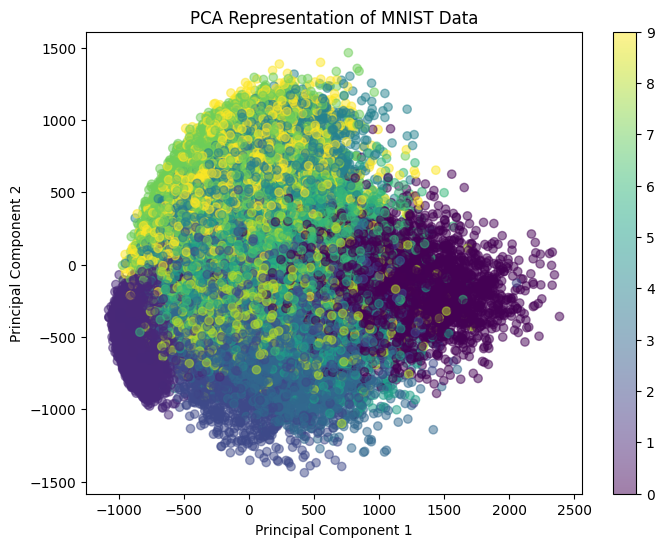

In [14]:
from sklearn.decomposition import PCA

# Convert y_train to numerical labels if it's in one-hot representation
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train_numeric = np.argmax(y_train, axis=1)
else:
    y_train_numeric = y_train  # Use y_train as is if it's already numerical

# Apply PCA to the training data to extract the first two principal components
pca = PCA(n_components=2)
X_train_pca_2d = pca.fit_transform(X_train)

# Ensure y_train_numeric is sliced to match the number of samples in X_train_pca_2d
y_train_sliced = y_train_numeric[:X_train_pca_2d.shape[0]]

# Plot the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train_sliced, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)  # Show a color bar
plt.title('PCA Representation of MNIST Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


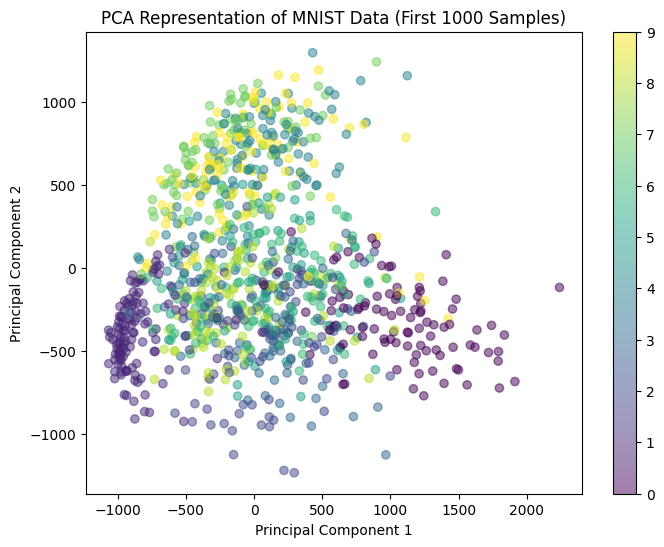

In [15]:
from sklearn.decomposition import PCA

# Select the first 1000 samples from the training data
X_train_sample = X_train[:1000]

# Convert y_train to numerical labels if it's in one-hot representation
if y_train.ndim > 1 and y_train.shape[1] > 1:
    y_train_numeric = np.argmax(y_train, axis=1)
else:
    y_train_numeric = y_train  # Use y_train as is if it's already numerical

# Apply PCA to the selected training data to extract the first two principal components
pca = PCA(n_components=2)
X_train_pca_2d = pca.fit_transform(X_train_sample)

# Ensure y_train_numeric is sliced to match the number of samples in X_train_pca_2d
y_train_sliced = y_train_numeric[:X_train_pca_2d.shape[0]]

# Plot the first two principal components
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train_sliced, cmap='viridis', alpha=0.5)
plt.colorbar(scatter)  # Show a color bar
plt.title('PCA Representation of MNIST Data (First 1000 Samples)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

### **Visualize the high-dimensional MNIST data in a 2D space using t-Distributed Stochastic Neighbor Embedding (t-SNE) and interpret the results.**

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_subset_tsne = tsne.fit_transform(X_subset)

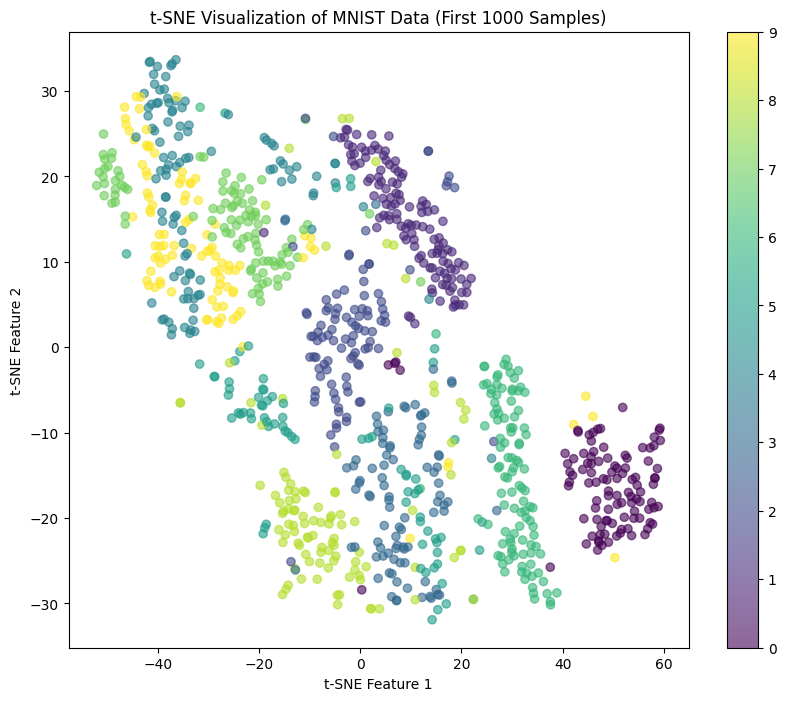

In [20]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_subset_tsne[:, 0], X_subset_tsne[:, 1], c=y_subset, cmap='viridis', alpha=0.6)
plt.colorbar(scatter)
plt.title("t-SNE Visualization of MNIST Data (First 1000 Samples)")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")
plt.show()

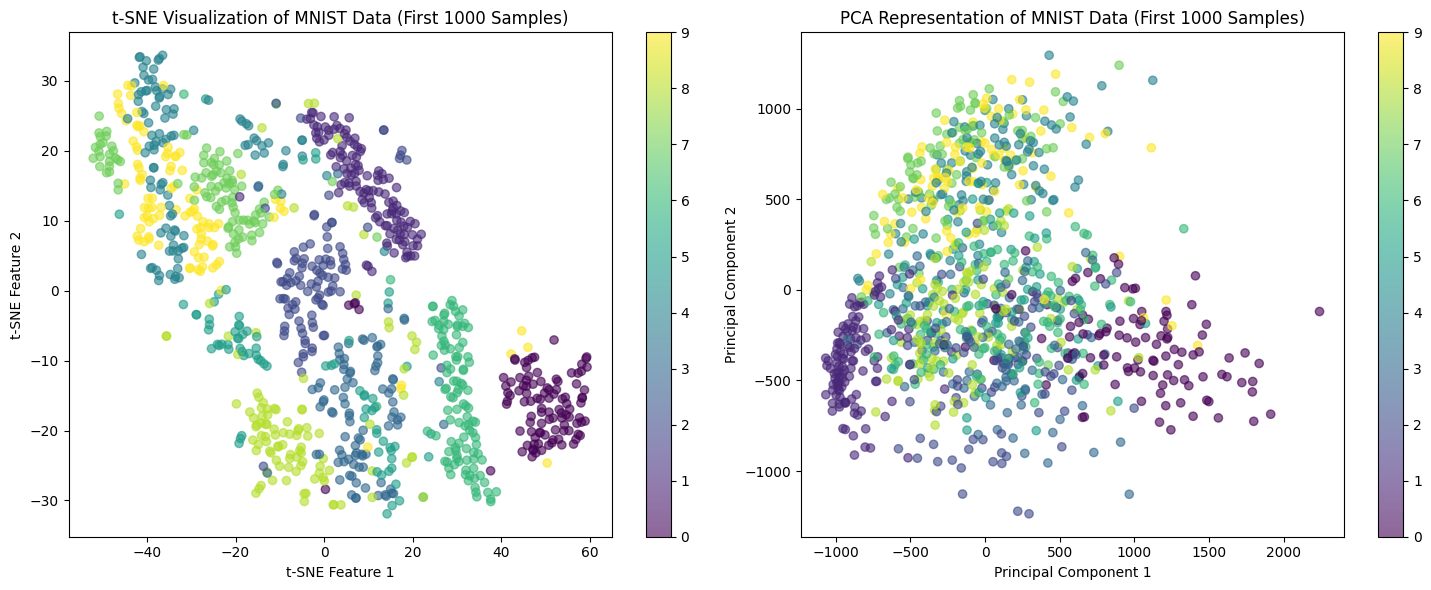

In [19]:
plt.figure(figsize=(15, 6))

# Plot t-SNE visualization
plt.subplot(1, 2, 1)
scatter_tsne = plt.scatter(X_subset_tsne[:, 0], X_subset_tsne[:, 1], c=y_subset, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_tsne)
plt.title("t-SNE Visualization of MNIST Data (First 1000 Samples)")
plt.xlabel("t-SNE Feature 1")
plt.ylabel("t-SNE Feature 2")

# Plot PCA visualization (assuming X_train_pca_2d is the PCA representation of the same subset of data)
plt.subplot(1, 2, 2)
scatter_pca = plt.scatter(X_train_pca_2d[:, 0], X_train_pca_2d[:, 1], c=y_train_sliced, cmap='viridis', alpha=0.6)
plt.colorbar(scatter_pca)
plt.title('PCA Representation of MNIST Data (First 1000 Samples)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.tight_layout()
plt.show()